In [1]:
anime_path = r"files/anime"


In [2]:
from torchvision import transforms as T
from torchvision.datasets import ImageFolder

transform = T.Compose([T.Resize((64, 64)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
train_data = ImageFolder(root=anime_path,
                         transform=transform)

In [3]:
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(dataset=train_data, 
               batch_size=batch_size, shuffle=True)

In [4]:
image0, _ = train_data[0]
print(image0.shape)

torch.Size([3, 64, 64])


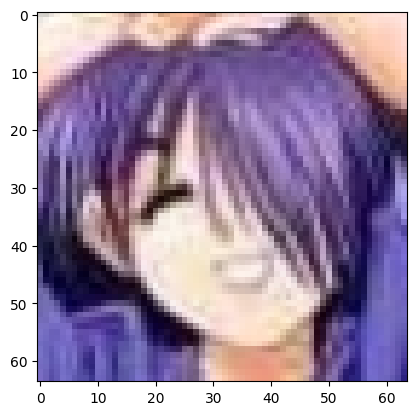

In [7]:
import matplotlib.pyplot as plt

plt.imshow(image0.permute(1,2,0)*0.5+0.5)
plt.show()

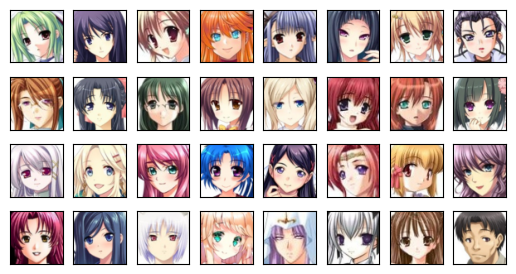

In [8]:
def plot_images(imgs):
    for i in range(32):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(imgs[i].permute(1,2,0)/2+0.5)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()  

imgs, _ = next(iter(train_loader))
plot_images(imgs)

In [9]:
import torch.nn as nn
import torch

# determine the device automatically
device = "cuda" if torch.cuda.is_available() else "cpu"
D = nn.Sequential(
    nn.Conv2d(3, 64, 4, 2, 1, bias=False),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(256, 512, 4, 2, 1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(512, 1, 4, 1, 0, bias=False),
    nn.Sigmoid(),
    nn.Flatten()).to(device)

In [10]:
G=nn.Sequential(
    nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
    nn.Tanh()).to(device)

In [11]:
loss_fn=nn.BCELoss()
lr = 0.0002
optimG = torch.optim.Adam(G.parameters(), 
                         lr = lr, betas=(0.5, 0.999))
optimD = torch.optim.Adam(D.parameters(), 
                         lr = lr, betas=(0.5, 0.999))

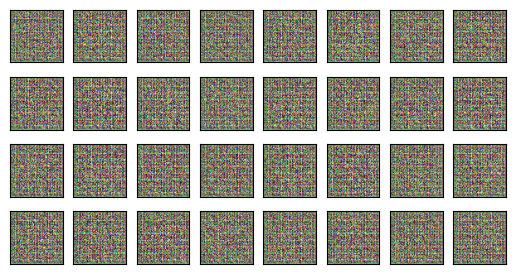

In [12]:
def test_epoch():
    noise=torch.randn(32,100,1,1).\
        to(device=device)    #A
    fake_samples=G(noise).cpu().detach()    #B
    for i in range(32):    #C
        ax = plt.subplot(4, 8, i + 1)
        img=(fake_samples.cpu().detach()[i]/2+0.5).\
            permute(1,2,0)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(hspace=-0.6)
    plt.show()
test_epoch()    #D     

In [13]:
real_labels=torch.ones((batch_size,1)).to(device)
fake_labels=torch.zeros((batch_size,1)).to(device)


In [14]:
def train_D_on_real(real_samples):
    real_samples=real_samples.to(device)
    preds=D(real_samples)
    labels=torch.ones((real_samples.shape[0],1)).to(device)
    loss_D=loss_fn(preds,labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D  

In [15]:
def train_D_on_fake():
    noise=torch.randn(batch_size,100,1,1).to(device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_D=loss_fn(preds,fake_labels)
    optimD.zero_grad()
    loss_D.backward()
    optimD.step()
    return loss_D 

In [16]:
def train_G():
    noise=torch.randn(batch_size,100,1,1).to(device)
    generated_data=G(noise)
    preds=D(generated_data)
    loss_G=loss_fn(preds,real_labels)
    optimG.zero_grad()
    loss_G.backward()
    optimG.step()
    return loss_G   

epoch 1, dloss: 0.565970778465271, gloss 6.619457721710205


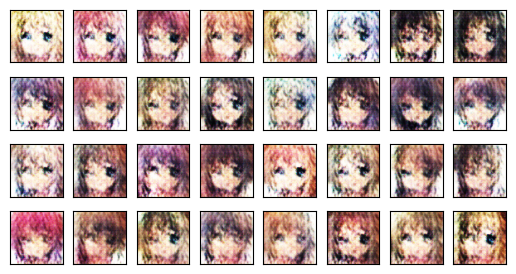

epoch 2, dloss: 0.46874547004699707, gloss 6.823483467102051


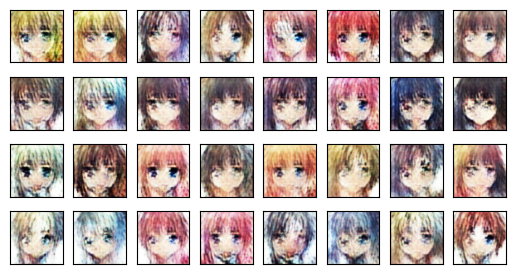

epoch 3, dloss: 0.40405476093292236, gloss 7.056826114654541


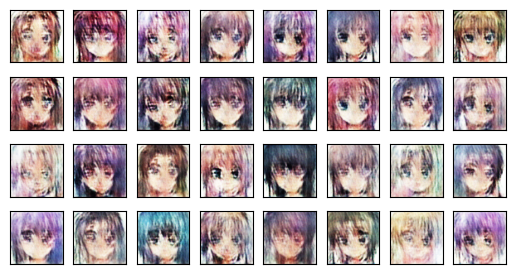

epoch 4, dloss: 0.3321686387062073, gloss 7.502983093261719


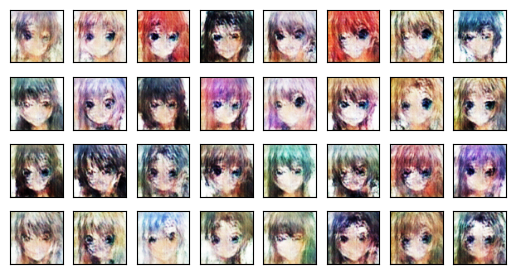

epoch 5, dloss: 0.2856062054634094, gloss 7.367923259735107


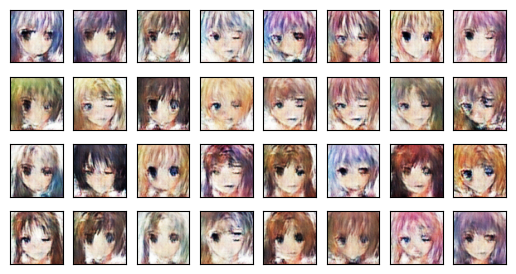

epoch 6, dloss: 0.29252469539642334, gloss 7.692976951599121


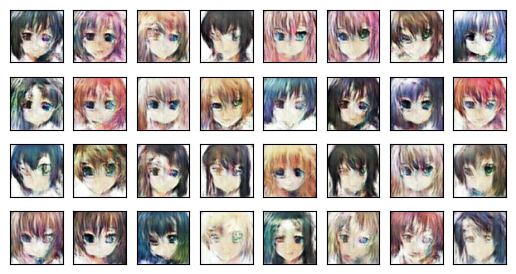

epoch 7, dloss: 0.2916368246078491, gloss 7.7110490798950195


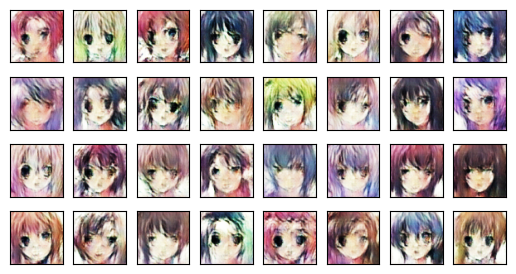

epoch 8, dloss: 0.26140281558036804, gloss 7.472727298736572


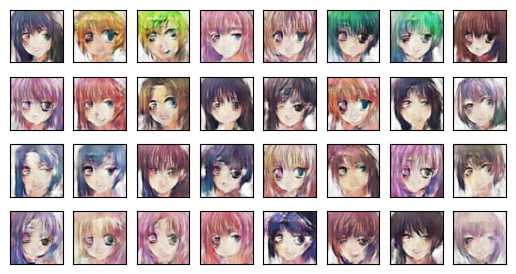

epoch 9, dloss: 0.2507483959197998, gloss 7.706725120544434


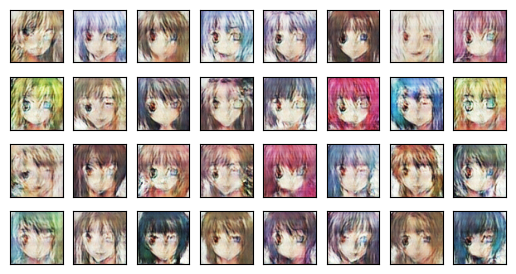

epoch 10, dloss: 0.2532791495323181, gloss 7.083208084106445


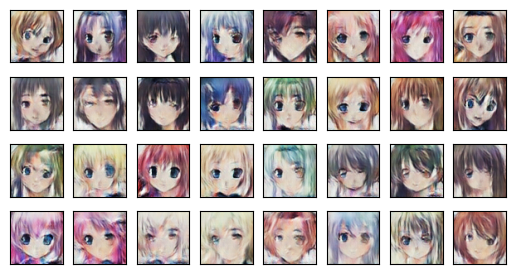

epoch 11, dloss: 0.2789493799209595, gloss 7.154621601104736


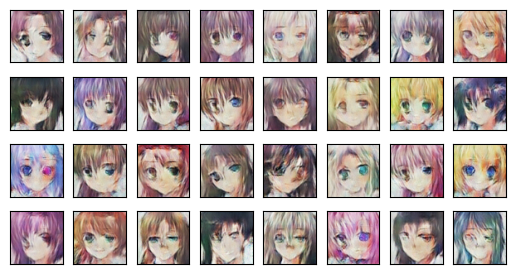

epoch 12, dloss: 0.314197301864624, gloss 7.035971641540527


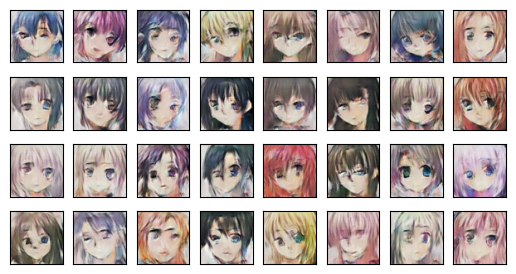

epoch 13, dloss: 0.2546538710594177, gloss 6.69498348236084


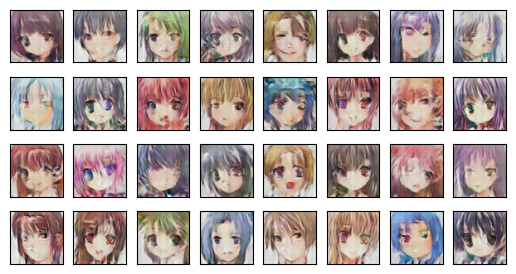

epoch 14, dloss: 0.28879955410957336, gloss 6.372169017791748


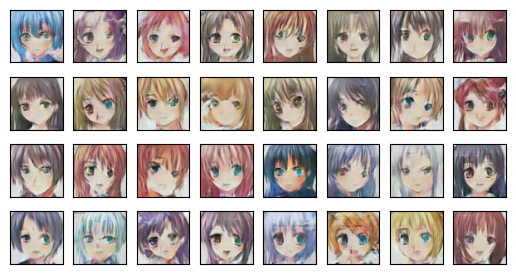

epoch 15, dloss: 0.30199915170669556, gloss 6.222362995147705


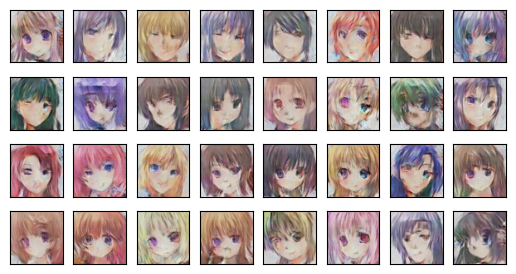

epoch 16, dloss: 0.3032282888889313, gloss 6.1765618324279785


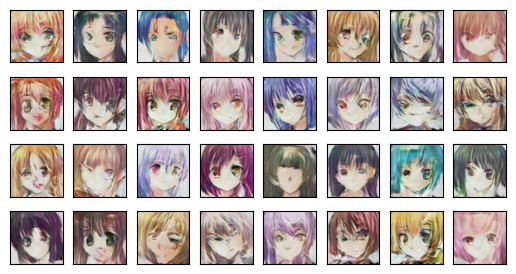

epoch 17, dloss: 0.2070978730916977, gloss 5.963938236236572


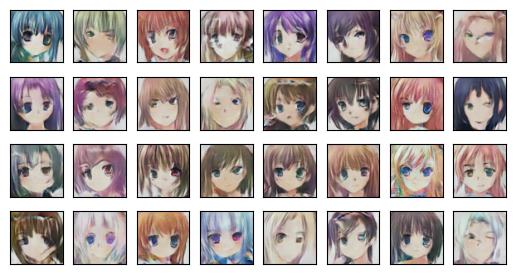

epoch 18, dloss: 0.3433799147605896, gloss 6.046535015106201


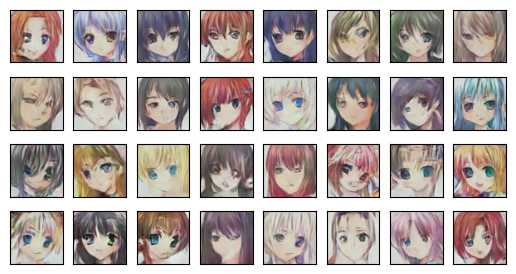

epoch 19, dloss: 0.30216625332832336, gloss 6.039759635925293


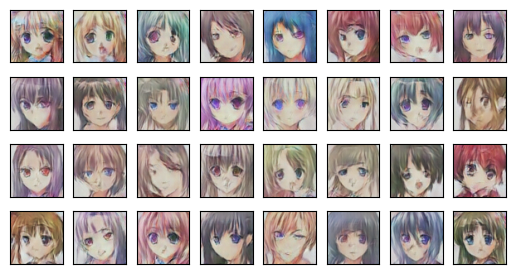

epoch 20, dloss: 0.21906128525733948, gloss 5.81444787979126


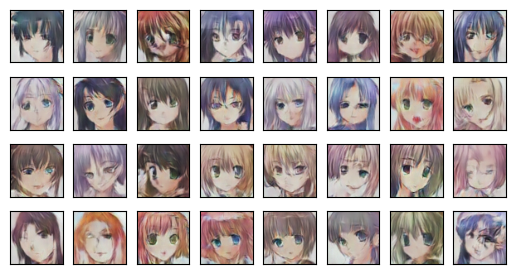

In [17]:
for i in range(20):
    gloss=0
    dloss=0
    for n, (real_samples,_) in enumerate(train_loader):    
        loss_D=train_D_on_real(real_samples)
        dloss+=loss_D
        loss_D=train_D_on_fake()
        dloss+=loss_D
        loss_G=train_G()
        gloss+=loss_G
    gloss=gloss/n
    dloss=dloss/n
    print(f"epoch {i+1}, dloss: {dloss}, gloss {gloss}")
    test_epoch()

In [18]:
# Export to TorchScript
scripted = torch.jit.script(G) 
scripted.save('files/anime_gen.pt') 

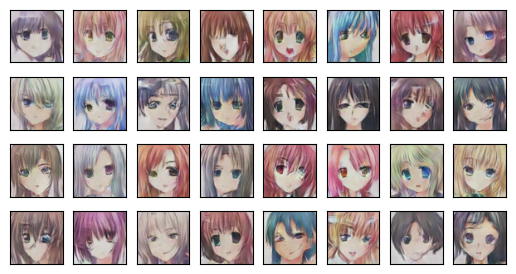

In [19]:
new_G=torch.jit.load('files/anime_gen.pt',
                     map_location=device)
new_G.eval()
noise=torch.randn(32,100,1,1).to(device)
fake_samples=new_G(noise).cpu().detach()
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    img=(fake_samples.cpu().detach()[i]/2+0.5).permute(1,2,0)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.subplots_adjust(hspace=-0.6)
plt.show() 